In [1]:
# Make sure that the funcs module is reloaded every time it's updated
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy.time import Time
from funcs import *

In [3]:
# Constants

sun_mass = const.M_sun.value # kg
sun_radius = const.R_sun.value # m
sun_luminosity = const.L_sun.value # W

star_mass = 0.69 * sun_mass # kg
star_radius = 0.669 * sun_radius # m
star_temperature = 4300 # K
period = 1.2410229 # days
period_seconds = period * 24 * 60**2 # s

grav_const = const.G.value # N m^2 kg^-2
earth_mass = const.M_earth.value # kg
earth_radius = const.R_earth.value # m
jupiter_mass = const.M_jup.value # kg
jupiter_radius = const.R_jup.value # m

# Saturn's mass and radius
saturn_mass = 568.51e24 # kg
saturn_radius = 60268000 # m

au = const.au.value # m

# Flux at earth
flux_at_earth = sun_luminosity / (4 * np.pi * au**2) # W m^-2

In [4]:
# Import data and assign variables
rv = np.load(r'JSAstroLab2024_rv_data.npz','r')

wl = rv['wavelength']
vel = rv['velocity']
model = rv['spec_template']

spectra = search_store(rv, 'spectrum')
time_rv = search_store(rv, 'time')

# Remove the time offest
offset = time_rv[0]
time_rv -= offset

trans = np.load(r'JSAstroLab2024_transit_data.npz','r')

time_transit = trans['time']
flux_transit = trans['flux']

ecli = np.load(r'JSAstroLab2024_eclipse_data.npz','r')

time_eclipse = ecli['time']
flux_eclipse = ecli['flux']

In [5]:
# Set font sizes

plt.rc('font', size=15)
plt.rc('axes', labelsize=15)
plt.rc('figure', titlesize=15)


# Task 1

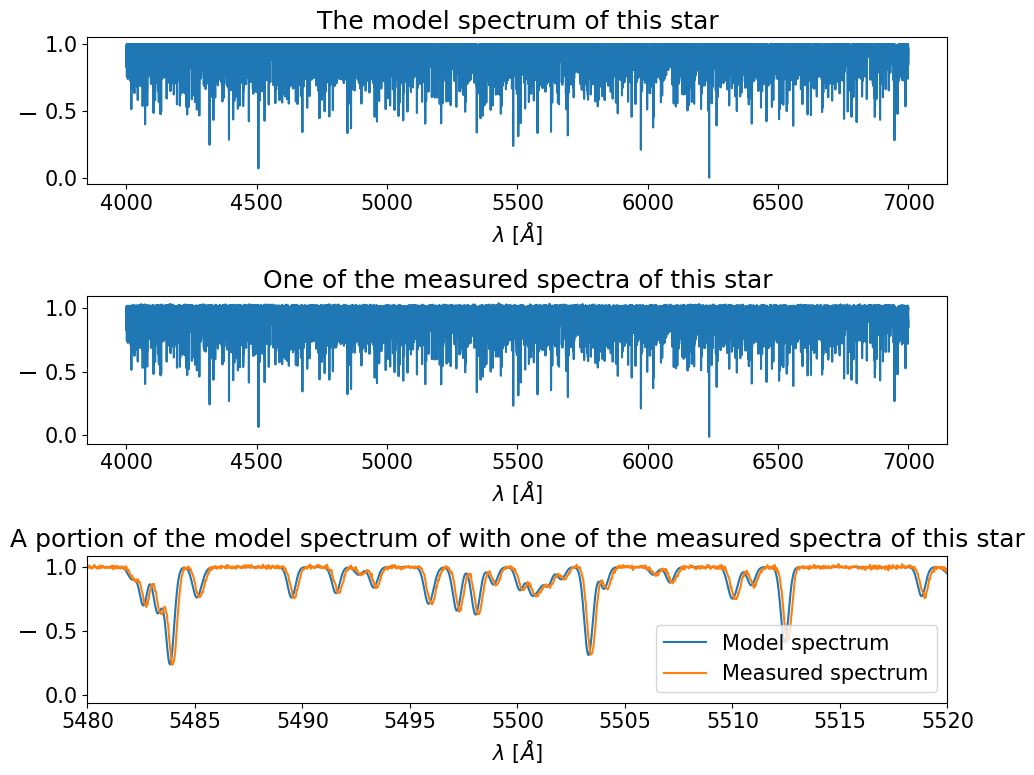

In [6]:
# Plot the model spectrum
fig, ax = plt.subplots(3, 1, figsize=(10,8))

ax[0].plot(wl, model)
ax[0].set_xlabel(r'$\lambda$ [$\AA$]')
ax[0].set_ylabel('I')
ax[0].set_title('The model spectrum of this star')

ax[1].plot(wl, spectra[2])
ax[1].set_xlabel(r'$\lambda$ [$\AA$]')
ax[1].set_ylabel('I')
ax[1].set_title('One of the measured spectra of this star')

ax[2].plot(wl, model, label='Model spectrum')
ax[2].plot(wl, spectra[2], label='Measured spectrum')
ax[2].set_xlabel(r'$\lambda$ [$\AA$]')
ax[2].set_ylabel('I')
ax[2].set_title('A portion of the model spectrum of with one of the measured spectra of this star')
ax[2].set_xlim([5480, 5520])
ax[2].legend()

fig.tight_layout()

In [7]:
# Correlation

# The mean of the model spectrum
mean_model = np.mean(model)

model_corr = model - mean_model

# Store velocity shifts
vel_shift = np.array([])
vel_shift_uncertainty = np.array([])

# Initial guess for each fit
p0 = [1200, -7300, 14000, 0]

for i in range(len(spectra)):
  # The spectrum to be correlated
  s = spectra[i]

  # Find the mean of the spectrum
  mean_s = np.mean(s)

  # Correlate the model and the observed spectrum
  corr = np.correlate(model_corr, s - mean_s, mode='same')

  # Fit the middle to a gaussian function
  p_fit, chi_score, uncertainty = fitting(p0, vel[55900:56000], corr[55900:56000], gauss)

  # Save the velocity shift (location of the peak of the gaussian) and the associated uncertainty
  vel_shift = np.append(vel_shift, p_fit[1])
  vel_shift_uncertainty = np.append(vel_shift_uncertainty, uncertainty[1])


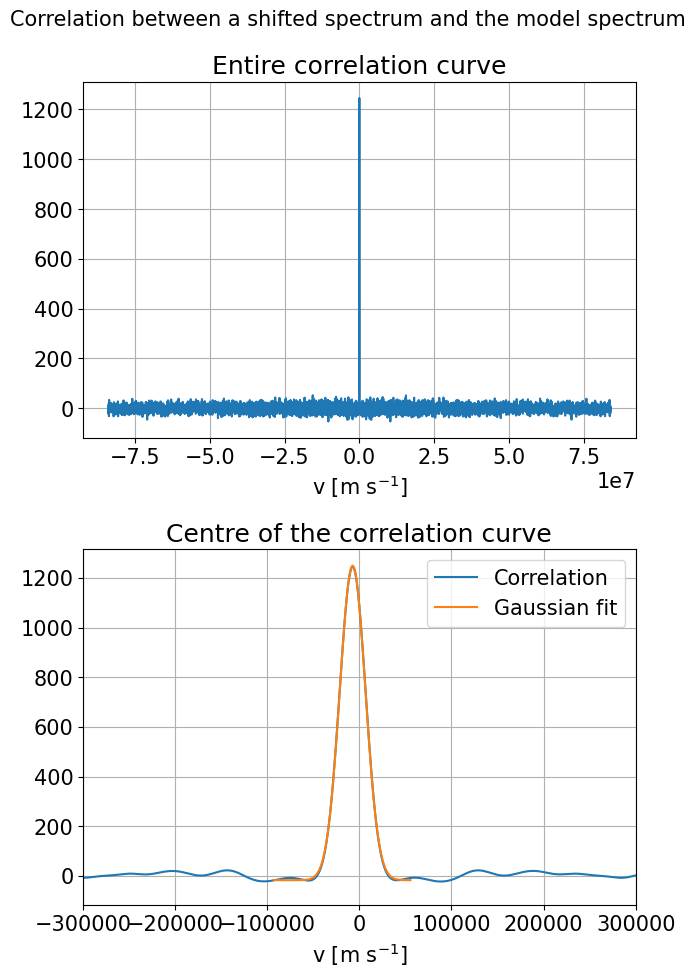

In [20]:
# Plot an example of a correlation curve with the fitted gaussian

# Choose the first spectrum
s = spectra[0]

# Find the mean of the spectrum
mean_s = np.mean(s)

# Correlate the model and the observed spectrum
corr = np.correlate(model - mean_model, s - mean_s, mode='same')

# Fit the correlation curve to a gaussian
p0 = [1200, -7300, 14000, 0]

p_fit, chi, uncertainty = fitting(p0, vel[55900:56000], corr[55900:56000], gauss)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(7, 10))

ax[0].plot(vel, corr)
ax[0].set_xlabel(r'v [m s$^{-1}$]')
ax[0].set_title('Entire correlation curve')
ax[0].grid()

ax[1].plot(vel, corr, label='Correlation')
ax[1].plot(vel[55900:56000], gauss(p_fit, vel[55900:56000]), label=f'Gaussian fit')
ax[1].set_xlabel(r'v [m s$^{-1}$]')
ax[1].set_title('Centre of the correlation curve')
ax[1].set_xlim([-300000, 300000])
ax[1].grid()
ax[1].legend()

fig.suptitle('Correlation between a shifted spectrum and the model spectrum')
fig.tight_layout()

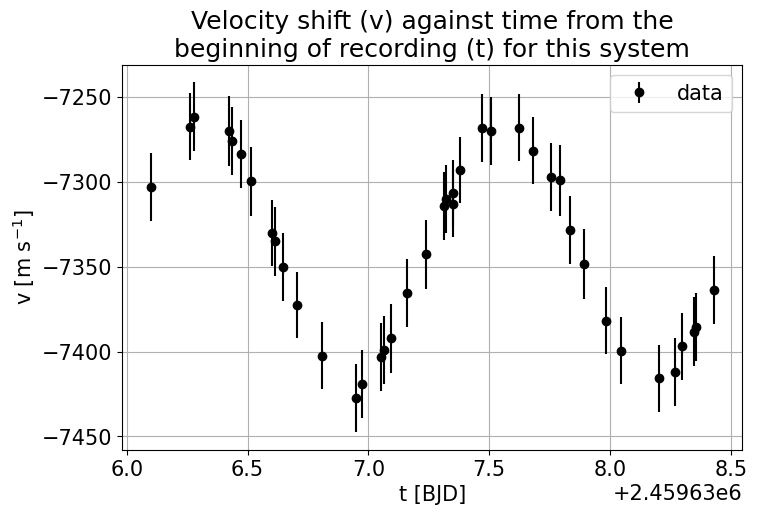

In [9]:
# Plot the velocity shift curve

fig, ax = plt.subplots(1, figsize=(8,5))

ax.errorbar(time_rv + offset, vel_shift, yerr=vel_shift_uncertainty, fmt='o', label='data', color='black')
ax.set_title('Velocity shift (v) against time from the\nbeginning of recording (t) for this system')
ax.set_xlabel('t [BJD]')
ax.set_ylabel(r'v [m s$^{-1}$]')
ax.grid()
ax.legend()

# Task 2

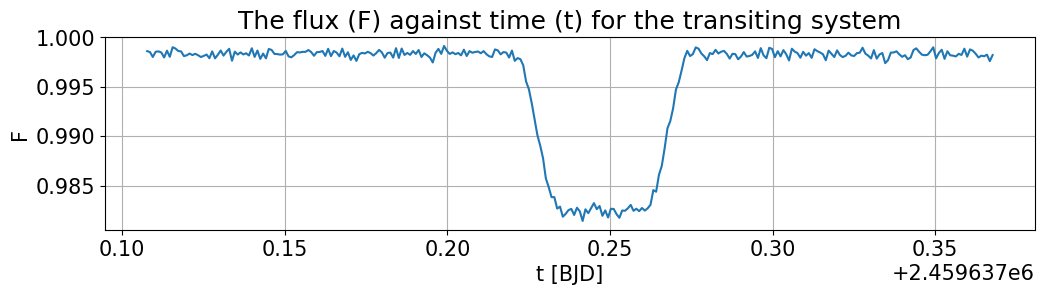

In [10]:
# Plot the light curve for the transiting system

fig, ax = plt.subplots(figsize=(12,2.5))

ax.plot(time_transit, flux_transit)
ax.set_xlabel('t [BJD]')
ax.set_ylabel('F')
ax.set_title('The flux (F) against time (t) for the transiting system')
ax.grid()

c:\Users\brend\Documents\_University\3 JS\Semester 2\Computational Labs\Assignment 1\funcs.py:179: RuntimeWarning: invalid value encountered in arccos
  k0 = np.arccos((rho**2 + z**2 - 1) / (2 * rho * z))
c:\Users\brend\Documents\_University\3 JS\Semester 2\Computational Labs\Assignment 1\funcs.py:180: RuntimeWarning: invalid value encountered in arccos
  k1 = np.arccos((1 - rho**2 + z**2) / (2 * z))


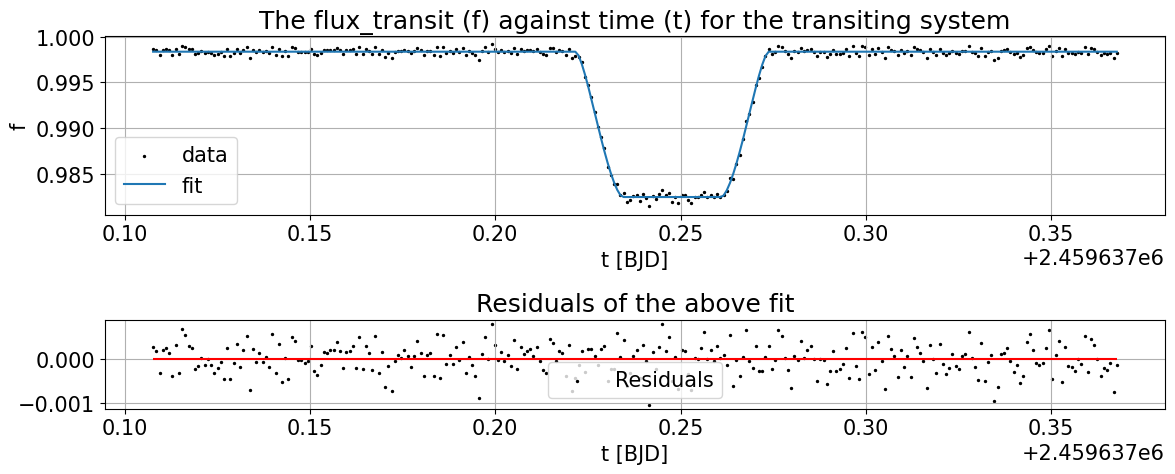

In [11]:
# Initial guess at parameters of the fit
p0 = [0.248 + 2.459637e6, 5.2, 0.127, np.pi/2 - 0.16, 0.9985]

# Fit the light curve to the transit function
p_fit, chi, uncertainty = fitting(p0, time_transit, flux_transit, transit)

# Plot the data, fit, and residuals
fig, ax = plt.subplots(2, figsize=(12,5), gridspec_kw={'height_ratios': [2, 1]})

ax[0].set_title('The flux_transit (f) against time (t) for the transiting system')
ax[0].set_ylabel('f')
ax[0].set_xlabel('t [BJD]')
ax[0].scatter(time_transit, flux_transit, label='data', s=2, color='black')
ax[0].plot(time_transit, transit(p_fit, time_transit), label='fit')
ax[0].legend()
ax[0].grid()

ax[1].set_title('Residuals of the above fit')
ax[1].scatter(time_transit, residuals(p_fit, transit, time_transit ,flux_transit), s=2, label='Residuals', color='black')
ax[1].hlines(0, min(time_transit), max(time_transit), color='red')
ax[1].set_xlabel('t [BJD]')
ax[1].legend()
ax[1].grid()

fig.tight_layout()

# Round the data to their uncertainties
p_fit_rnd, uncertainty_rnd = round_sig_fig_uncertainty(p_fit, uncertainty)

# Store the information gathered by this fit
t_cent, a, rho, inclination = p_fit[0:4]
t_cent_uncertainty, a_uncertainty, rho_uncertainty, inclination_uncertainty = uncertainty[0:4]


Rplanet = rho * star_radius
smaj = a * star_radius

# Assuming no uncertainties in the radius of the star
Rplanet_uncertainty = rho_uncertainty * star_radius
smaj_uncertainty = a_uncertainty * star_radius

# Round these values
smaj_rnd, smaj_uncertainty_rnd = round_sig_fig_uncertainty(smaj, smaj_uncertainty)
a_rnd, a_uncertainty_rnd = round_sig_fig_uncertainty(a, a_uncertainty)
rho_rnd, rho_uncertainty_rnd = round_sig_fig_uncertainty(rho, rho_uncertainty)
Rplanet_rnd, Rplanet_uncertainty_rnd = round_sig_fig_uncertainty(Rplanet, Rplanet_uncertainty)
inclination_rnd, inclination_uncertainty_rnd = round_sig_fig_uncertainty(inclination, inclination_uncertainty)

In [12]:
# The planet's radius and tranist parameters

p_labels = ['Semi-major axis', 'Planet to star radius ratio', 'Orbital inclination', 'The flut out of transit']
p_units = ['Stellar radii', '', 'rad', '']

t0 = Time(p_fit_rnd[0], format='jd')
t0 = t0.to_datetime()

t0_uncertainty = uncertainty[0] * 24 * 60**2


print(f'Central transit time = {p_fit_rnd[0]} \u00B1 { uncertainty_rnd[0]} BJD')
print(f'= {t0}')

for i in range(1,p_fit_rnd.size):
  print(f"{p_labels[i-1]} = {p_fit_rnd[i]} \u00B1 { uncertainty_rnd[i]} {p_units[i-1]}")

print('\n')

print(f"Planet's radius = {p_fit_rnd[2]} \u00B1 { uncertainty_rnd[2]} Stellar radii")
print(f"= {Rplanet_rnd} \u00B1 {Rplanet_uncertainty_rnd} m")
print(f'= {round_sig_fig_uncertainty(Rplanet / earth_radius, Rplanet_uncertainty / earth_radius)[0]} \u00B1 {round_sig_fig_uncertainty(Rplanet / earth_radius, Rplanet_uncertainty / earth_radius)[1]} Earth radii')
print(f'= {round_sig_fig_uncertainty(Rplanet / jupiter_radius, Rplanet_uncertainty / jupiter_radius)[0]} \u00B1 {round_sig_fig_uncertainty(Rplanet / jupiter_radius, Rplanet_uncertainty / jupiter_radius)[1]} Jupiter radii')

print('\n')

print(f"Planet's semi-major axis = {a_rnd} \u00B1 {a_uncertainty_rnd} Stellar radii")
print(f'= {smaj_rnd} \u00B1 {smaj_uncertainty_rnd} m')
print(f'= {round_sig_fig_uncertainty(smaj / au, smaj_uncertainty / au)[0]} \u00B1 {round_sig_fig_uncertainty(smaj / au, smaj_uncertainty / au)[1]} au')

print('\n')

print(f"Planet's orbital inclination = {inclination_rnd} \u00B1 {inclination_uncertainty_rnd} rad")
print(f'= {round_sig_fig_uncertainty(inclination * 180/np.pi, inclination_uncertainty * 180/np.pi)[0]} \u00B1 {round_sig_fig_uncertainty(inclination * 180/np.pi, inclination_uncertainty * 180/np.pi)[1]} degrees')

Central transit time = 2459637.24772 ± 0.00014 BJD
= 2022-02-26 17:56:43.007989
Semi-major axis = 6.38 ± 0.05 Stellar radii
Planet to star radius ratio = 0.1261 ± 0.0004 
Orbital inclination = 1.451 ± 0.0018 rad
The flut out of transit = 0.99834 ± 2e-05 


Planet's radius = 0.1261 ± 0.0004 Stellar radii
= 58700000.0 ± 170000.0 m
= 9.2 ± 0.03 Earth radii
= 0.821 ± 0.002 Jupiter radii


Planet's semi-major axis = 6.38 ± 0.05 Stellar radii
= 2970000000.0 ± 30000000.0 m
= 0.01984 ± 0.00017 au


Planet's orbital inclination = 1.451 ± 0.0018 rad
= 83.14 ± 0.1 degrees


# Task 3

Amplitude = 77.0 ± 1.0
Phase shift = 0.463 ± 0.012
Systemic velocity = -7340.0 ± 0.7


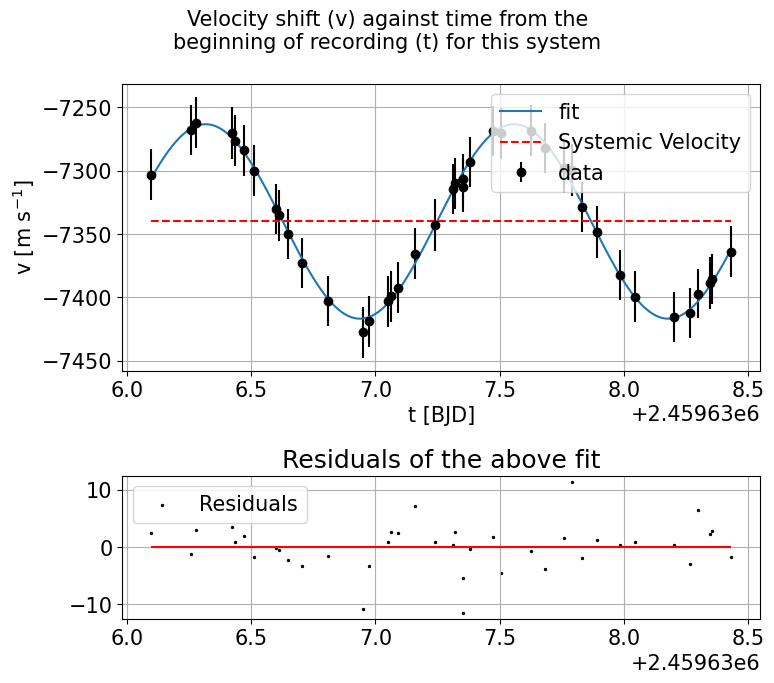

In [13]:
# Fit the radical velocity graph

p0 = [70, -1, -7350]


p_fit, chi, uncertainty = fitting(p0, time_rv, vel_shift, sin)

# Make an array of time values to smoothly plot the fit
t = np.linspace(min(time_rv), max(time_rv), 1000)


# Plot the data, fit, and residuals
fig, ax = plt.subplots(2, figsize=(8,7), gridspec_kw={'height_ratios': [2, 1]})

fig.suptitle('Velocity shift (v) against time from the\nbeginning of recording (t) for this system')
ax[0].set_ylabel(r'v [m s$^{-1}$]')
ax[0].set_xlabel('t [BJD]')
ax[0].errorbar(time_rv + offset, vel_shift, yerr=vel_shift_uncertainty, fmt='o', label='data', color='black')
ax[0].plot(t + offset, sin(p_fit, t), label='fit')
ax[0].hlines(p_fit[2], min(time_rv + offset), max(time_rv + offset), color='red', linestyle='--', label='Systemic Velocity')
ax[0].legend(loc=1)
ax[0].grid()


ax[1].set_title('Residuals of the above fit')
ax[1].scatter(time_rv + offset, residuals(p_fit, sin, time_rv, vel_shift), s=2, label='Residuals', color='black')
ax[1].hlines(0, t[0] + offset, t[-1] + offset, color='red')
ax[1].legend()
ax[1].grid()

fig.tight_layout()

# Round the fit parameters to their uncertainties
p_fit_rnd, uncertainty_rnd = round_sig_fig_uncertainty(p_fit, uncertainty)

# Print the fit parameters
p_labels=['Amplitude', 'Phase shift', 'Systemic velocity']
for i in range(p_fit.size):
  print(f"{p_labels[i]} = {p_fit_rnd[i]} \u00B1 { uncertainty_rnd[i]}")


# Save values for later
kstar, kstar_uncertainty = p_fit[0], uncertainty[0]
sys_vel, sys_vel_uncertainty = p_fit[2], uncertainty[2]

# Round system velocity
sys_vel_rnd, sys_vel_uncertainty_rnd = round_sig_fig_uncertainty(sys_vel, sys_vel_uncertainty)

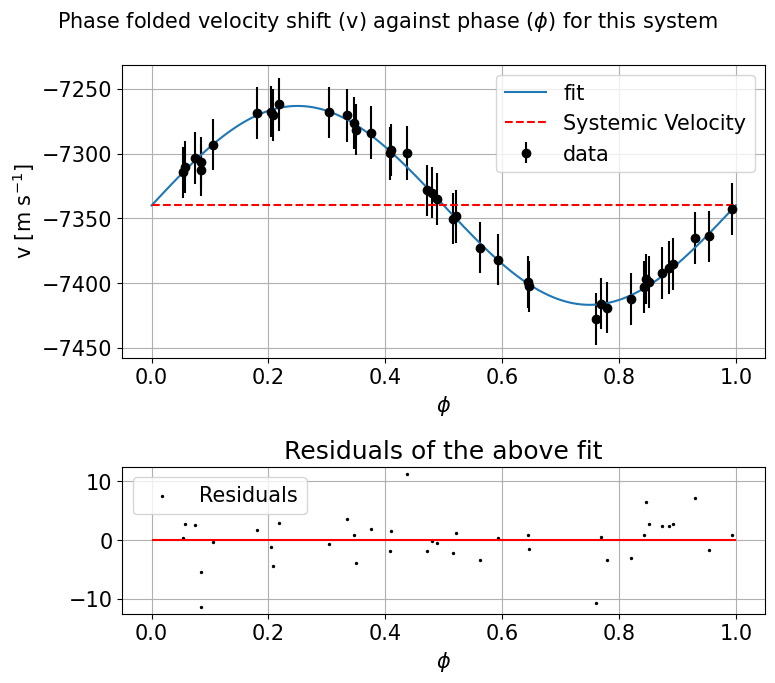

In [14]:
# Phase fold the data
time_rv_folded = (time_rv + offset - t_cent)%period / period

# Make an array of time values to smoothly plot the fit
t_folded = np.linspace(0, 1, 1000)

# Plot the data, fit, and residuals
fig, ax = plt.subplots(2, figsize=(8,7), gridspec_kw={'height_ratios': [2, 1]})

fig.suptitle(r'Phase folded velocity shift (v) against phase ($\phi$) for this system')
ax[0].set_ylabel(r'v [m s$^{-1}$]')
ax[0].set_xlabel(r'$\phi$')
ax[0].errorbar(time_rv_folded, vel_shift, yerr=vel_shift_uncertainty, fmt='o', label='data', color='black')
ax[0].plot(t_folded, sin((p_fit[0], 0, p_fit[2]), t_folded, period=1), label='fit')
ax[0].hlines(p_fit[2], min(t_folded), max(t_folded), color='red', linestyle='--', label='Systemic Velocity')
ax[0].legend()
ax[0].grid()

ax[1].set_title('Residuals of the above fit')
ax[1].set_xlabel(r'$\phi$')
ax[1].scatter(time_rv_folded, residuals(p_fit, sin, time_rv, vel_shift), s=2, label='Residuals', color='black')
ax[1].hlines(0, t_folded[0], t_folded[-1], color='red')
ax[1].legend()
ax[1].grid()

fig.tight_layout()


# Task 4

In [15]:
# Calculate stellar and planetary parameters

# Luminosity of the star
star_luminosity = 4 * np.pi * star_radius**2 * const.sigma_sb.value * star_temperature**4

## Mass of the planet
# Assuming i = pi/2 rad
# Assuming star_mass >> planet_mass, so star_mass + planet_mass approx= star_mass

planet_mass_min = kstar * star_mass**(2/3) * (period_seconds / (2 * np.pi * grav_const))**(1/3)

# Assuming no uncertainty in stellar mass or orbital period
planet_mass_min_uncertainty = kstar_uncertainty * star_mass**(2/3) * (period_seconds / (2 * np.pi * grav_const))**(1/3)

# Taking i from the transit curve
# Still assuming star_mass >> planet_mass, so Ms + planet_mass approx= Ms

planet_mass_approx = kstar * star_mass**(2/3) / np.sin(inclination) * (period_seconds / (2 * np.pi * grav_const))**(1/3)
planet_mass_approx_uncertainty = kstar_uncertainty * star_mass**(2/3) / np.sin(inclination) * (period_seconds / (2 * np.pi * grav_const))**(1/3)

# Find the planet's mass numerically
planet_mass, planet_mass_uncertainty = find_planet_mass(star_mass, inclination, period_seconds, kstar, kstar_uncertainty, planet_mass_approx, planet_mass_approx_uncertainty)

# Planet density
planet_density = planet_mass / (4/3 * np.pi * (Rplanet)**3)
earth_density = earth_mass / (4/3 * np.pi * (earth_radius)**3)
jupiter_density = jupiter_mass / (4/3 * np.pi * (jupiter_radius)**3)
saturn_density = saturn_mass / (4/3 * np.pi * (saturn_radius)**3)

# Using grav_constauss's law for uncertainty
planet_density_uncertainty = np.sqrt((planet_mass_uncertainty / (4/3 * np.pi * Rplanet**3))**2 + (-3 * planet_mass / (4/3 * np.pi * (Rplanet)**4) * Rplanet_uncertainty)**2)



# Flux at the planet
Fplanet = star_luminosity / (4*np.pi*smaj**2)

Fplanet_uncertainty = star_luminosity / (4*np.pi) * 2 * smaj**(-3) * smaj_uncertainty


# Round
planet_mass_min_rnd, planet_mass_min_uncertainty_rnd = round_sig_fig_uncertainty(planet_mass_min, planet_mass_min_uncertainty)
planet_mass_approx_rnd, planet_mass_approx_uncertainty_rnd = round_sig_fig_uncertainty(planet_mass_approx, planet_mass_approx_uncertainty)
planet_mass_rnd, planet_mass_uncertainty_rnd = round_sig_fig_uncertainty(planet_mass, planet_mass_uncertainty)
planet_density_rnd, planet_density_uncertainty_rnd = round_sig_fig_uncertainty(planet_density, planet_density_uncertainty)
Fplanet_rnd, Fplanet_uncertainty_rnd = round_sig_fig_uncertainty(Fplanet, Fplanet_uncertainty)


In [16]:
# Print all the known or derived parameters
print(f'Systemic velocity = {sys_vel_rnd} \u00B1 {sys_vel_uncertainty_rnd} m/s')

print('\n')

print('--- Stellar parameters ---')

print('\n')

print(f"Star's radius = {round_sig_fig(star_radius, 3)} m")
print(f'= {star_radius / sun_radius} Solar radii')

print('\n')

print(f"Star's mass = {round_sig_fig(star_mass, 2)} kg")
print(f'= {star_mass / sun_mass} Solar masses')

print('\n')

print(f"Star's temperature = {star_temperature} K")

print('\n')

print(f"Star's luminosity = {round_sig_fig(star_luminosity, 2)} W")
print(f'= {round_sig_fig(star_luminosity / sun_luminosity, 2)} Solar luminosities')

print('\n')

print('--- Planetary parameters ---')

print('\n')

print(f"Planet's radius = {rho_rnd} \u00B1 {rho_uncertainty_rnd} Stellar radii")
print(f"= {Rplanet_rnd} \u00B1 {Rplanet_uncertainty_rnd} m")
print(f'= {round_sig_fig_uncertainty(Rplanet / earth_radius, Rplanet_uncertainty / earth_radius)[0]} \u00B1 {round_sig_fig_uncertainty(Rplanet / earth_radius, Rplanet_uncertainty / earth_radius)[1]} Earth radii')
print(f'= {round_sig_fig_uncertainty(Rplanet / jupiter_radius, Rplanet_uncertainty / jupiter_radius)[0]} \u00B1 {round_sig_fig_uncertainty(Rplanet / jupiter_radius, Rplanet_uncertainty / jupiter_radius)[1]} Jupiter radii')
print(f'= {round_sig_fig_uncertainty(Rplanet / saturn_radius, Rplanet_uncertainty / saturn_radius)[0]} \u00B1 {round_sig_fig_uncertainty(Rplanet / saturn_radius, Rplanet_uncertainty / saturn_radius)[1]} Saturn radii')

print('\n')

print(f"Planet's semi-major axis = {a_rnd} \u00B1 {a_uncertainty_rnd} Stellar radii")
print(f'= {smaj_rnd} \u00B1 {smaj_uncertainty_rnd} m')
print(f'= {round_sig_fig_uncertainty(smaj / au, smaj_uncertainty / au)[0]} \u00B1 {round_sig_fig_uncertainty(smaj / au, smaj_uncertainty / au)[1]} au')

print('\n')

print(f"Planet's orbital inclination = {inclination_rnd} \u00B1 {inclination_uncertainty_rnd} rad")
print(f'= {round_sig_fig_uncertainty(inclination * 180/np.pi, inclination_uncertainty * 180/np.pi)[0]} \u00B1 {round_sig_fig_uncertainty(inclination * 180/np.pi, inclination_uncertainty * 180/np.pi)[1]} degrees')

print('\n')

print(f"Minimum bound on planet's mass = {planet_mass_min_rnd} \u00B1 {planet_mass_min_uncertainty_rnd} kg")
print(f'= {round_sig_fig_uncertainty(planet_mass_min / earth_mass, planet_mass_min_uncertainty / earth_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass_min / earth_mass, planet_mass_min_uncertainty / earth_mass)[1]} Earth masses')
print(f'= {round_sig_fig_uncertainty(planet_mass_min / jupiter_mass, planet_mass_min_uncertainty / jupiter_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass_min / jupiter_mass, planet_mass_min_uncertainty / jupiter_mass)[1]} Jupiter masses')
print(f'= {round_sig_fig_uncertainty(planet_mass_min / saturn_mass, planet_mass_min_uncertainty / saturn_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass_min / saturn_mass, planet_mass_min_uncertainty / saturn_mass)[1]} Saturn masses')

print('\n')

print(f"Approximation of planet's mass = {planet_mass_approx_rnd} \u00B1 {planet_mass_approx_uncertainty_rnd} kg")
print(f'= {round_sig_fig_uncertainty(planet_mass_approx / earth_mass, planet_mass_approx_uncertainty / earth_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass_approx / earth_mass, planet_mass_approx_uncertainty / earth_mass)[1]} Earth masses')
print(f'= {round_sig_fig_uncertainty(planet_mass_approx / jupiter_mass, planet_mass_approx_uncertainty / jupiter_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass_approx / jupiter_mass, planet_mass_approx_uncertainty / jupiter_mass)[1]} Jupiter masses')
print(f'= {round_sig_fig_uncertainty(planet_mass_approx / saturn_mass, planet_mass_approx_uncertainty / saturn_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass_approx / saturn_mass, planet_mass_approx_uncertainty / saturn_mass)[1]} Saturn masses')

print('\n')

print(f"Planet's mass = {planet_mass_rnd} \u00B1 {planet_mass_uncertainty_rnd} kg")
print(f'= {round_sig_fig_uncertainty(planet_mass / earth_mass, planet_mass_uncertainty / earth_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass / earth_mass, planet_mass_uncertainty / earth_mass)[1]} Earth masses')
print(f'= {round_sig_fig_uncertainty(planet_mass / jupiter_mass, planet_mass_uncertainty / jupiter_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass / jupiter_mass, planet_mass_uncertainty / jupiter_mass)[1]} Jupiter masses')
print(f'= {round_sig_fig_uncertainty(planet_mass / saturn_mass, planet_mass_uncertainty / saturn_mass)[0]} \u00B1 {round_sig_fig_uncertainty(planet_mass / saturn_mass, planet_mass_uncertainty / saturn_mass)[1]} Saturn masses')

print('\n')

print(f"Planet's density = {planet_density_rnd} \u00B1 {planet_density_uncertainty_rnd} kg m^-3")
print(f"= {round_sig_fig_uncertainty(planet_density / earth_density, planet_density_uncertainty / earth_density)[0]} \u00B1 {round_sig_fig_uncertainty(planet_density / earth_density, planet_density_uncertainty / earth_density)[1]} Earth densities")
print(f"= {round_sig_fig_uncertainty(planet_density / jupiter_density, planet_density_uncertainty / jupiter_density)[0]} \u00B1 {round_sig_fig_uncertainty(planet_density / jupiter_density, planet_density_uncertainty / jupiter_density)[1]} Jupiter densities")
print(f"= {round_sig_fig_uncertainty(planet_density / saturn_density, planet_density_uncertainty / saturn_density)[0]} \u00B1 {round_sig_fig_uncertainty(planet_density / saturn_density, planet_density_uncertainty / saturn_density)[1]} Saturn densities")

print('\n')

print(f"Planet's orbital period = {period} days")

print('\n')

print(f"Flux at the planet = {Fplanet_rnd} \u00B1 {Fplanet_uncertainty_rnd} W m^-2")
print(f'= {round_sig_fig_uncertainty(Fplanet_rnd / flux_at_earth, Fplanet_uncertainty_rnd / flux_at_earth)[0]} \u00B1 {round_sig_fig_uncertainty(Fplanet_rnd / flux_at_earth, Fplanet_uncertainty_rnd / flux_at_earth)[1]} flux received at Earth')

Systemic velocity = -7340.0 ± 0.7 m/s


--- Stellar parameters ---


Star's radius = 465000000.0 m
= 0.669 Solar radii


Star's mass = 1.4e+30 kg
= 0.69 Solar masses


Star's temperature = 4300 K


Star's luminosity = 5.3e+25 W
= 0.14 Solar luminosities


--- Planetary parameters ---


Planet's radius = 0.1261 ± 0.0004 Stellar radii
= 58700000.0 ± 170000.0 m
= 9.2 ± 0.03 Earth radii
= 0.821 ± 0.002 Jupiter radii
= 0.974 ± 0.003 Saturn radii


Planet's semi-major axis = 6.38 ± 0.05 Stellar radii
= 2970000000.0 ± 30000000.0 m
= 0.01984 ± 0.00017 au


Planet's orbital inclination = 1.451 ± 0.0018 rad
= 83.14 ± 0.1 degrees


Minimum bound on planet's mass = 6.02e+26 ± 8e+24 kg
= 100.8 ± 1.3 Earth masses
= 0.317 ± 0.004 Jupiter masses
= 1.059 ± 0.014 Saturn masses


Approximation of planet's mass = 6.06e+26 ± 8e+24 kg
= 101.5 ± 1.3 Earth masses
= 0.319 ± 0.004 Jupiter masses
= 1.066 ± 0.014 Saturn masses


Planet's mass = 6.06e+26 ± 8e+24 kg
= 101.5 ± 1.3 Earth masses
= 0.319 ± 0.004 Jupite

# Eclipse

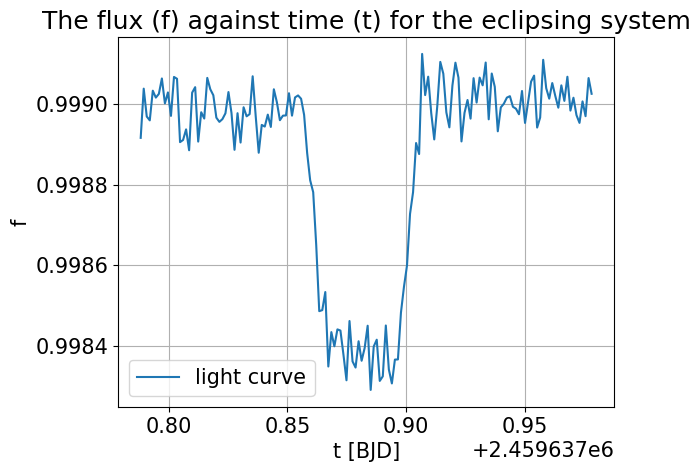

In [17]:
# Please ignore this section, I was unable to find the correct equation to use for the eclipse function
plt.plot(time_eclipse, flux_eclipse, label='light curve')
plt.xlabel('t [BJD]')
plt.ylabel('f')
plt.title('The flux (f) against time (t) for the eclipsing system')
plt.grid()
plt.legend()

c:\Users\brend\Documents\_University\3 JS\Semester 2\Computational Labs\Assignment 1\funcs.py:225: RuntimeWarning: invalid value encountered in arccos
  k0 = np.arccos((rho**2 + z**2 - 1) / (2 * rho * z))
c:\Users\brend\Documents\_University\3 JS\Semester 2\Computational Labs\Assignment 1\funcs.py:226: RuntimeWarning: invalid value encountered in arccos
  k1 = np.arccos((1 - rho**2 + z**2) / (2 * z))


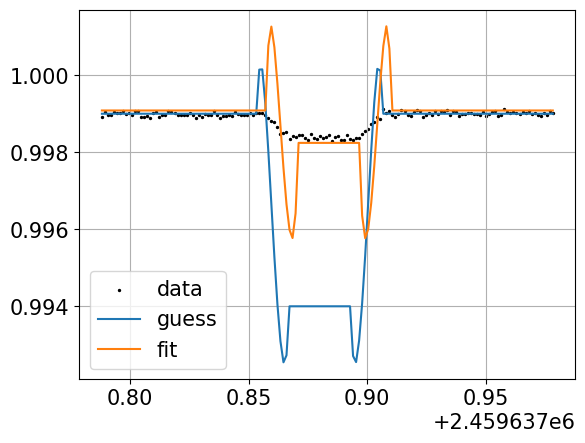

In [18]:
p0 = [0.88 + 2.459637e6, 0.999, 0.005]

#p0 = [0.88 + 2.459637e6, 5.2, 0.127, np.pi/2 - 0.16, 0.9985]

# t0, a, rho, i, foot

p_fit, chi, uncertainty = fitting(p0, time_eclipse, flux_eclipse, eclipse)


plt.scatter(time_eclipse, flux_eclipse, label='data', s=2, color='black')
plt.plot(time_eclipse, eclipse(p0, time_eclipse), label='guess')
plt.plot(time_eclipse, eclipse(p_fit, time_eclipse), label='fit')

plt.legend()
plt.grid()

In [19]:
f = eclipse(p0, time_eclipse)[0]
k0 = eclipse(p0, time_eclipse)[1]
k1 = eclipse(p0, time_eclipse)[2]
index=eclipse(p0, time_eclipse)[3]

print(f[index])
print(k0[index])
print(k1[index])

print(eclipse(p0, time_eclipse)[4][index])
print(eclipse(p0, time_eclipse)[5][index])


IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(time_eclipse, z)
plt.hlines([1 - rho, 1 + rho], time_eclipse[0], time_eclipse[-1])

In [ ]:
eclipse(p0, time_eclipse)